In [43]:
## For the cv2 libGL error install the package inside the docker container using docker exec -it apt-get install -y libgl1-mesa-dev
## https://codeslake.github.io/ubuntu/docker/docker-libGL-error/
!pip install --upgrade pip
!pip install opencv-python
!pip install pillow
!pip install matplotlib
!pip install tqdm
!pip install scikit-learn
!pip install scikit-image
!pip install cython

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)


In [44]:
## Data transformation pipeline in opencv
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from PIL import Image
from PIL import ImageFilter
import matplotlib
from tqdm import tqdm_notebook
from skimage.util import random_noise


In [45]:
## Globals
##IMAGE_SHAPE = [32, 32, 3]
##IMAGE_RESIZED_SHAPE = [32, 32]
SHARPNESS_FACTOR = 0.4
EPSILON = 1e-5
NUM_DEBUG_IMAGES = 3

### **Data Loading from TFRECORD**

In [46]:
## The path where the tf record file is
## The record file is generated using the utils.py in the PINNDL repo (check under the module)
file_name = '/tf/data/pascalvoc_max_32_set.tfrecords'
## Load the raw tf record file from the file system
raw_image_dataset = tf.data.TFRecordDataset(file_name)
print(raw_image_dataset) ## gives no much information since the parsing of a tfrecord file is not yet implemented
## To parse a tfrecord file, one needs the structure of the record file (How the data is structured when they are saved)

<TFRecordDatasetV2 shapes: (), types: tf.string>


In [47]:
## Make the structure that would help us to parse the TFRecord file
## feature descriptor dict
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [48]:
## Now we make a function that an iterator can take as an higher oder function
def _parser_image_function(example_proto):
    ## Parse a single image feature structure
    ## serialized byte --> _parser_image_function(feature description) --> parsed image structure (see image_example function)
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [49]:
parsed_image_dataset = raw_image_dataset.map(_parser_image_function)
#for image_feature in parsed_image_dataset:
#  image_out = tf.io.decode_raw(image_feature['image_raw'], out_type=tf.uint8)
#  print(image_out)
## Now we have access to the keys of the dataset data structure (keys are defined in the feature descreption dict).
def image_label(image_features):
  image_out = tf.io.decode_raw(image_features['image_raw'], out_type=tf.uint8)
  image_label = image_features['label']
  image_shape = [image_features['height'], image_features['width'], image_features['depth']]

  return image_out, image_label, image_shape

### **Defining an Augmentation Strategy**

In [50]:
## a simple function to add noise to an image (case 2)
## https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
def add_noise(image, image_shape):
  '''
  output_image = np.zeros(image_shape)
  for d in range(image_shape[2]):
    for h in range(image_shape[0]):
      for w in range(image_shape[1]):
          #rnd_num = random.random()
          rnd_num = np.random.normal(0.8, 0.3)
          #print(rnd_num)
          if rnd_num < prob:
            output_image[h][w][d] = 0
          elif rnd_num > prob and rnd_num < (1 - prob):
            output_image[h][w][d] = 255
          else:
            output_image[h][w][d] = image[h][w][d]
    '''
  ## make some gaussian noise
  ## normalize to 0-1 
  image = image / 255.0
  
  ## var = 0.1, stdv = sqrt(0.1)
  noise = np.random.normal(loc=0.0, scale=0.01**0.5, size=image_shape) ## (image hight, image width, channels)
  ## add noise to the image
  
  output_image = image.astype(np.float) + noise
  output_image = np.clip(output_image, 0.0, 255.0)
  ## and rescale to 255
  #min_val = np.min(output_image)
  #max_val = np.max(output_image)
  #output_image = (output_image - min_val) / (max_val - min_val)
  
  #output_image = output_image * 255.0
  #output_image = random_noise(image, mode="gaussian")
  #print(output_image)
  return output_image

## Defin image augmentation function. This function should put a set of augmentations
## based on a random number
#### stor augmention functions (just a demonstration)
function_dict = {
    "0": cv2.blur,
    "1": add_noise,
    "2": cv2.flip,
}

In [51]:
image_label_dataset = parsed_image_dataset.map(image_label)

### **Define a generator to generate augmented data**


In [52]:
'''
for img, lbl, img_shape in image_label_dataset:
  choice = np.random.randint(0, 2)
  img = np.reshape(img.numpy(), img_shape)
  lbl = lbl.numpy()
  ## set the function inputs
  if choice == 0:
    param = (5, 5)
    ## function to exec:
    aug_func = function_dict[str(choice)]
    img = aug_func(img,param)
  elif choice == 1:
    param_1 = (0, 0, 0)
    param_2 = (1, 1, 1)
    ## function to exec:
    aug_func = function_dict[str(choice)]
    img = aug_func(img,param_1, param_2)

  #augmented_image_list.append(img)
'''
#### The generator that transforms images and output them one by one####
#### more on generators: https://realpython.com/introduction-to-python-generators/ ####
def transform_image():
  for img, lbl, img_shape in image_label_dataset:
    choice = np.random.randint(0, 3)
    img = np.reshape(img.numpy(), img_shape)
    #lbl = lbl.numpy()
    ## set the function inputs
    if choice == 0:
      param = (5, 5)
      ## function to exec:
      aug_func = function_dict[str(choice)]
      img = aug_func(img,param)
    elif choice == 1:
      ## function to exec:
      aug_func = function_dict[str(choice)]
      img = aug_func(img,img_shape)
    elif choice == 3:
      ## function to exec:
      aug_func = function_dict[str(choice)]
      img = aug_func(img)
    img = tf.convert_to_tensor(img, tf.uint8)
    
    yield img, lbl
    
#### This time we create the dataset from a generator instead of a function map
transformed_image_label_dataset = image_label_dataset.from_generator(transform_image, (tf.uint8, tf.int64))
## check if all the images are there
#lbl_list = list()
#for _, lbl in transformed_image_label_dataset:
#  lbl_list.append(lbl)
#print(len(lbl_list))
#print(choice)
#print(img.shape)

### **Get the sobel filter (Edge detection) response**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


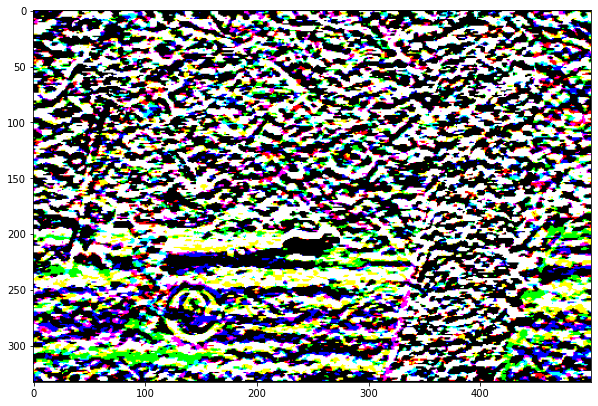

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


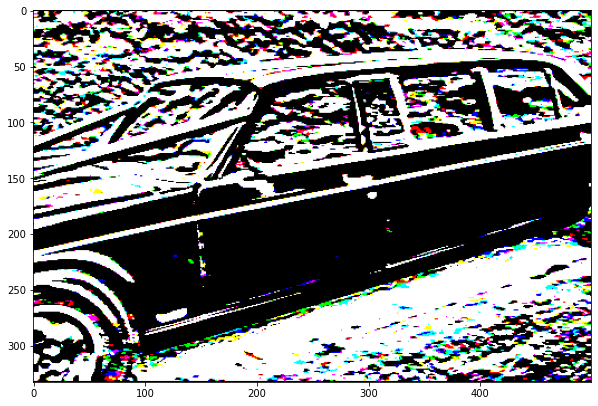

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


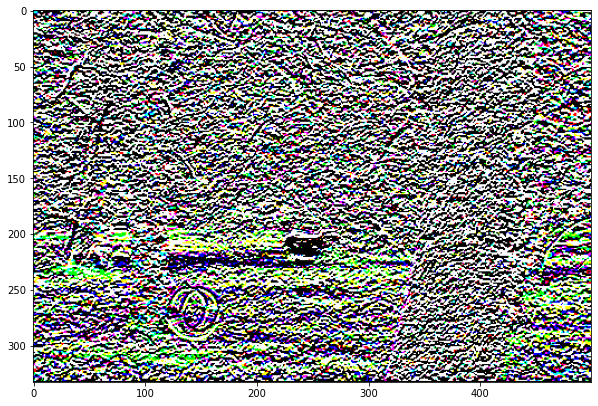

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


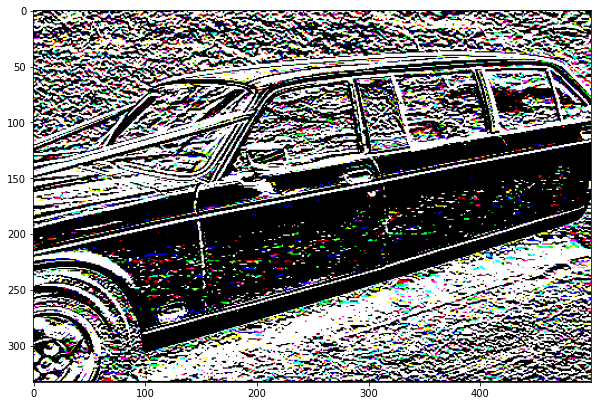

In [53]:
count = 1
fig = plt.figure()
matplotlib.rcParams['figure.figsize'] = [10, 10]
## On Image features: https://en.wikipedia.org/wiki/Feature_detection_(computer_vision)
## On Sobel filters: https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm
for t_img, t_lbl in transformed_image_label_dataset.take(2):
  #img = np.reshape(img.numpy(), img_shape)
  t_img = t_img.numpy()
  ## sobel image of transformed
  sobel_x = cv2.Sobel(t_img,cv2.CV_64F,1,0,ksize=3)
  sobel_y = cv2.Sobel(t_img,cv2.CV_64F,0,1,ksize=3)
  #fig.add_subplot(30, 2, count)
  #plt.imshow(img)
  #fig.add_subplot(30, 2, count+1)
  plt.imshow(sobel_y)
  plt.show()
  #print(img.shape)
for t_img, t_lbl, img_shape in image_label_dataset.take(2):
  #img = np.reshape(img.numpy(), img_shape)
  img = np.reshape(t_img.numpy(), img_shape)
  ## sobel image of transformed
  sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
  sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
  #fig.add_subplot(30, 2, count)
  #plt.imshow(img)
  #fig.add_subplot(30, 2, count+1)
  plt.imshow(sobel_y)
  plt.show()

In [ ]:
## First We load the data (tfrecords)
    ## Parse the content of the record file into a dataset
    ## We use data transformation startegy on the parsed dataset 
    ## We create a new transformed dataset

### **Plot histograms to see feature difference**

In [54]:
'''
## check the histograms
## On histogram: https://homepages.inf.ed.ac.uk/rbf/HIPR2/histgram.htm
matplotlib.rcParams['figure.figsize'] = [20, 20]
fig, axs = plt.subplots(4, 2)
count = 0
for (t_img, t_lbl), (img, lbl, img_shape) in zip(transformed_image_label_dataset.take(4), image_label_dataset.take(4)) :
  t_img = t_img.numpy()
  t_img_gray = cv2.cvtColor(t_img, cv2.COLOR_RGB2GRAY)
  #print(img_gray.shape)
  ## image histogram
  t_hist = cv2.calcHist([t_img_gray],[0], None, [256], [0, 256])
  axs[count, 0].plot(t_hist)
  
  img = np.reshape(img.numpy(), img_shape)
  img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  #print(img_gray.shape)
  ## image histogram
  hist = cv2.calcHist([img_gray],[0], None, [256], [0, 256])
  axs[count, 1].plot(hist)

  count += 1

plt.show()
'''

"\n## check the histograms\n## On histogram: https://homepages.inf.ed.ac.uk/rbf/HIPR2/histgram.htm\nmatplotlib.rcParams['figure.figsize'] = [20, 20]\nfig, axs = plt.subplots(4, 2)\ncount = 0\nfor (t_img, t_lbl), (img, lbl, img_shape) in zip(transformed_image_label_dataset.take(4), image_label_dataset.take(4)) :\n  t_img = t_img.numpy()\n  t_img_gray = cv2.cvtColor(t_img, cv2.COLOR_RGB2GRAY)\n  #print(img_gray.shape)\n  ## image histogram\n  t_hist = cv2.calcHist([t_img_gray],[0], None, [256], [0, 256])\n  axs[count, 0].plot(t_hist)\n  \n  img = np.reshape(img.numpy(), img_shape)\n  img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\n  #print(img_gray.shape)\n  ## image histogram\n  hist = cv2.calcHist([img_gray],[0], None, [256], [0, 256])\n  axs[count, 1].plot(hist)\n\n  count += 1\n\nplt.show()\n"